In [34]:
from src.environments.market import Market

m = Market("2013-02-12", "2013-02-14", 3)
a = m.reset()
print(a[1,:,:])

[[6.77142000e+01 6.84014000e+01 6.68928000e+01 6.78542000e+01
  1.58168416e+08]
 [6.80714000e+01 6.92771000e+01 6.76071000e+01 6.85614000e+01
  1.29029425e+08]
 [6.85014000e+01 6.89114000e+01 6.68205000e+01 6.68428000e+01
  1.51829363e+08]]


In [35]:
a,b,c = m.step()
print(a[1,:,:], b[1,:,:], c, sep='\n')
print(m.next_step, m.step_to_date())

[[6.77142000e+01 6.84014000e+01 6.68928000e+01 6.78542000e+01
  1.58168416e+08]
 [6.80714000e+01 6.92771000e+01 6.76071000e+01 6.85614000e+01
  1.29029425e+08]
 [6.85014000e+01 6.89114000e+01 6.68205000e+01 6.68428000e+01
  1.51829363e+08]]
[[6.80714000e+01 6.92771000e+01 6.76071000e+01 6.85614000e+01
  1.29029425e+08]
 [6.85014000e+01 6.89114000e+01 6.68205000e+01 6.68428000e+01
  1.51829363e+08]
 [6.67442000e+01 6.76628000e+01 6.61742000e+01 6.67156000e+01
  1.18721995e+08]]
False
1 2013-02-12


[*********************100%***********************]  1 of 1 completed
(17, 755, 5)


<Figure size 432x288 with 0 Axes>

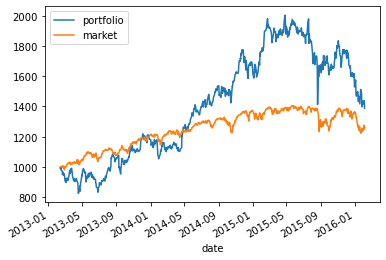

In [1]:
from src.environments.portfolio import Portfolio
import numpy as np

p = Portfolio("2013-02-12", "2016-02-05", 3, continuous=False)
print(p.market.data.shape)

p.reset()
while True:
    #action = np.random.rand(17)
    action = -1000000 * np.ones(17)
    action[1] = 1000000
    a,b,c,d = p.step(action)
    if c:
        break

p.render()

(750.0, 2000.0)

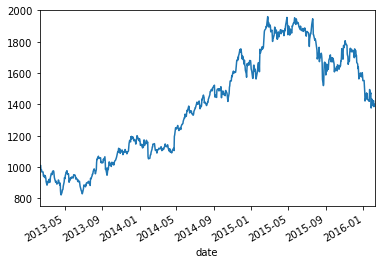

In [4]:
import pandas as pd

a = pd.read_csv('data/AAPL_data.csv')
a['date'] = pd.to_datetime(a['date'], format='%Y-%m-%d')
a.set_index('date', inplace=True)
a['close'] = a['close'].apply(lambda x : x / a.iloc[0]['close'] * 1000)
ax = a['close'].plot()
ax.set_xlim(pd.Timestamp('2013-02-08'), pd.Timestamp('2016-02-07'))
ax.set_ylim(750, 2000)

In [1]:
from src.environments.portfolio import Portfolio

p = Portfolio("2013-02-12", "2016-02-05", 3, continuous=False)

obs = p.reset()
print(obs[1,2,3])
obs[1,2,3] = 1
print(p.market.data[1,2,3])

[*********************100%***********************]  1 of 1 completed
66.8428
66.8428
